# Cyclic Vacuum Swing Adsorption simulation
This example shows how to set up and run a cyclic vacuum swing adsorption
simulation as described in [Haghpanah et al. 2013](http://dx.doi.org/10.1021/ie302658y)

This simulation inolves injection of a two component flue gas (CO2 and N2)
into a column of Zeolite 13X. The CO2 is preferentially adsorbed onto the zeolite.
Pressure in the column is then reduced to enable desorption of CO2 for collection.

This is a four stage process comprising:
* Pressurisation: Where the RHS of the column is closed and flue gas is injected from the LHS, at velocity $v_{feed}$, to bring the column pressure up to $P_H$ (Pressure High).
* Adsorption: Where both ends of the column are open and flue gas is injected from the RHS at velocity $v_{feed}$. Pressure at the LHS is $P_H$.
* Blowdown: Where the LHS of the column is closed and the column is evacuated at $P_I$ (Pressure Intermediate).
* Evacuation: Where the RHS of the column is closed and the column is evacuated from the LHS at $P_L$ (Pressure Low).

Each stage is modelled using the same governing equations but with different boundary
conditions. Adsorption onto Zeolite 13X is modelled with a dual-site Langmuir adsorption isotherm.

First we load the necessary modules

In [1]:
import Jutul
import JutulDarcy
import Mocca

We define parameters, and set up the system and domain as in the [Simulate DCB](simulate_DCB.md) example.

In [2]:
constants = Mocca.HaghpanahConstants{Float64}()
permeability = Mocca.compute_permeability(constants)
axial_dispersion = Mocca.calc_dispersion(constants)
system = Mocca.TwoComponentAdsorptionSystem(; permeability = permeability, dispersion = axial_dispersion, p = constants)

ncells = 200
dx = sqrt(pi*constants.r_in^2)
mesh = Jutul.CartesianMesh((ncells, 1, 1), (constants.L, dx, dx))
domain = Mocca.mocca_domain(mesh, system);

# Create the model
Now we can assemble the model which contains the domain and the system of equations.

In [3]:
model = Jutul.SimulationModel(domain, system; general_ad = true);

# Set up the initial state

In [4]:
bar = Jutul.si_unit(:bar)
P_init = 1*bar
T_init = 298.15
Tw_init = constants.T_a

yCO2 = fill(1e-10, ncells)
y_init = hcat(yCO2, 1 .- yCO2)

state0, prm = Mocca.initialise_state_AdsorptionColumn(P_init, T_init, Tw_init, y_init, model);

# Set up the stage timings

Here we have 4 stages and we specify a duration in seconds that we will run each stage.

In [5]:
t_press = 15
t_ads = 15
t_blow = 30
t_evac= 40

t_stage = [t_press, t_ads, t_blow, t_evac];

We also calculate the time taken to run one cycle and the total time at the end of each stage.

In [6]:
cycle_time = sum(t_stage)
step_end = cumsum(t_stage);

# Set up boundary conditions

We use different boundary conditions for each stage as described above.
These boundary conditions are already programmed in Mocca. We just need to define their parameters.

In [7]:
d_press = Mocca.PressurisationBC(y_feed = constants.y_feed, PH = constants.p_high, PL = constants.p_low,
                                λ = constants.λ, T_feed = constants.T_feed, cell_left = 1, cell_right = ncells,
                                cycle_time = cycle_time, previous_step_end = 0)

d_ads = Mocca.AdsorptionBC(y_feed = constants.y_feed, PH = constants.p_high, v_feed = constants.v_feed,
                                T_feed = constants.T_feed, cell_left = 1, cell_right = ncells)

d_blow = Mocca.BlowdownBC(PH = constants.p_high, PI = constants.p_intermediate,
                            λ = constants.λ, cell_left = 1, cell_right = ncells,
                            cycle_time = cycle_time, previous_step_end = step_end[2])


d_evac = Mocca.EvacuationBC(PL = constants.p_low, PI = constants.p_intermediate,
                            λ = constants.λ, cell_left = 1, cell_right = ncells,
                            cycle_time = cycle_time, previous_step_end = step_end[3]);

We collect the boundary conditions in the order of their associated stages

In [8]:
bcs = [d_press, d_ads, d_blow, d_evac];

Define the full cyclic simulation by stacking subsequent stages in time
for a specified number of cycles

In [9]:
numcycles = 3

timesteps = []
sim_forces = []
maxdt = 1

for j = 1:numcycles
    for i in eachindex(t_stage)
        numsteps = t_stage[i] / maxdt
        append!(timesteps, repeat([maxdt], Int(floor(numsteps))))
        append!(sim_forces, repeat([Jutul.setup_forces(model, bc=bcs[i])], Int(floor(numsteps))))
    end
end

# Simulate
Now we are ready to run the simulation.

In [10]:
states, report = Jutul.simulate(state0, model, timesteps;
    forces=sim_forces,
    parameters = prm,
    info_level = -1
);

# Plot
We plot primary variables at the outlet through time

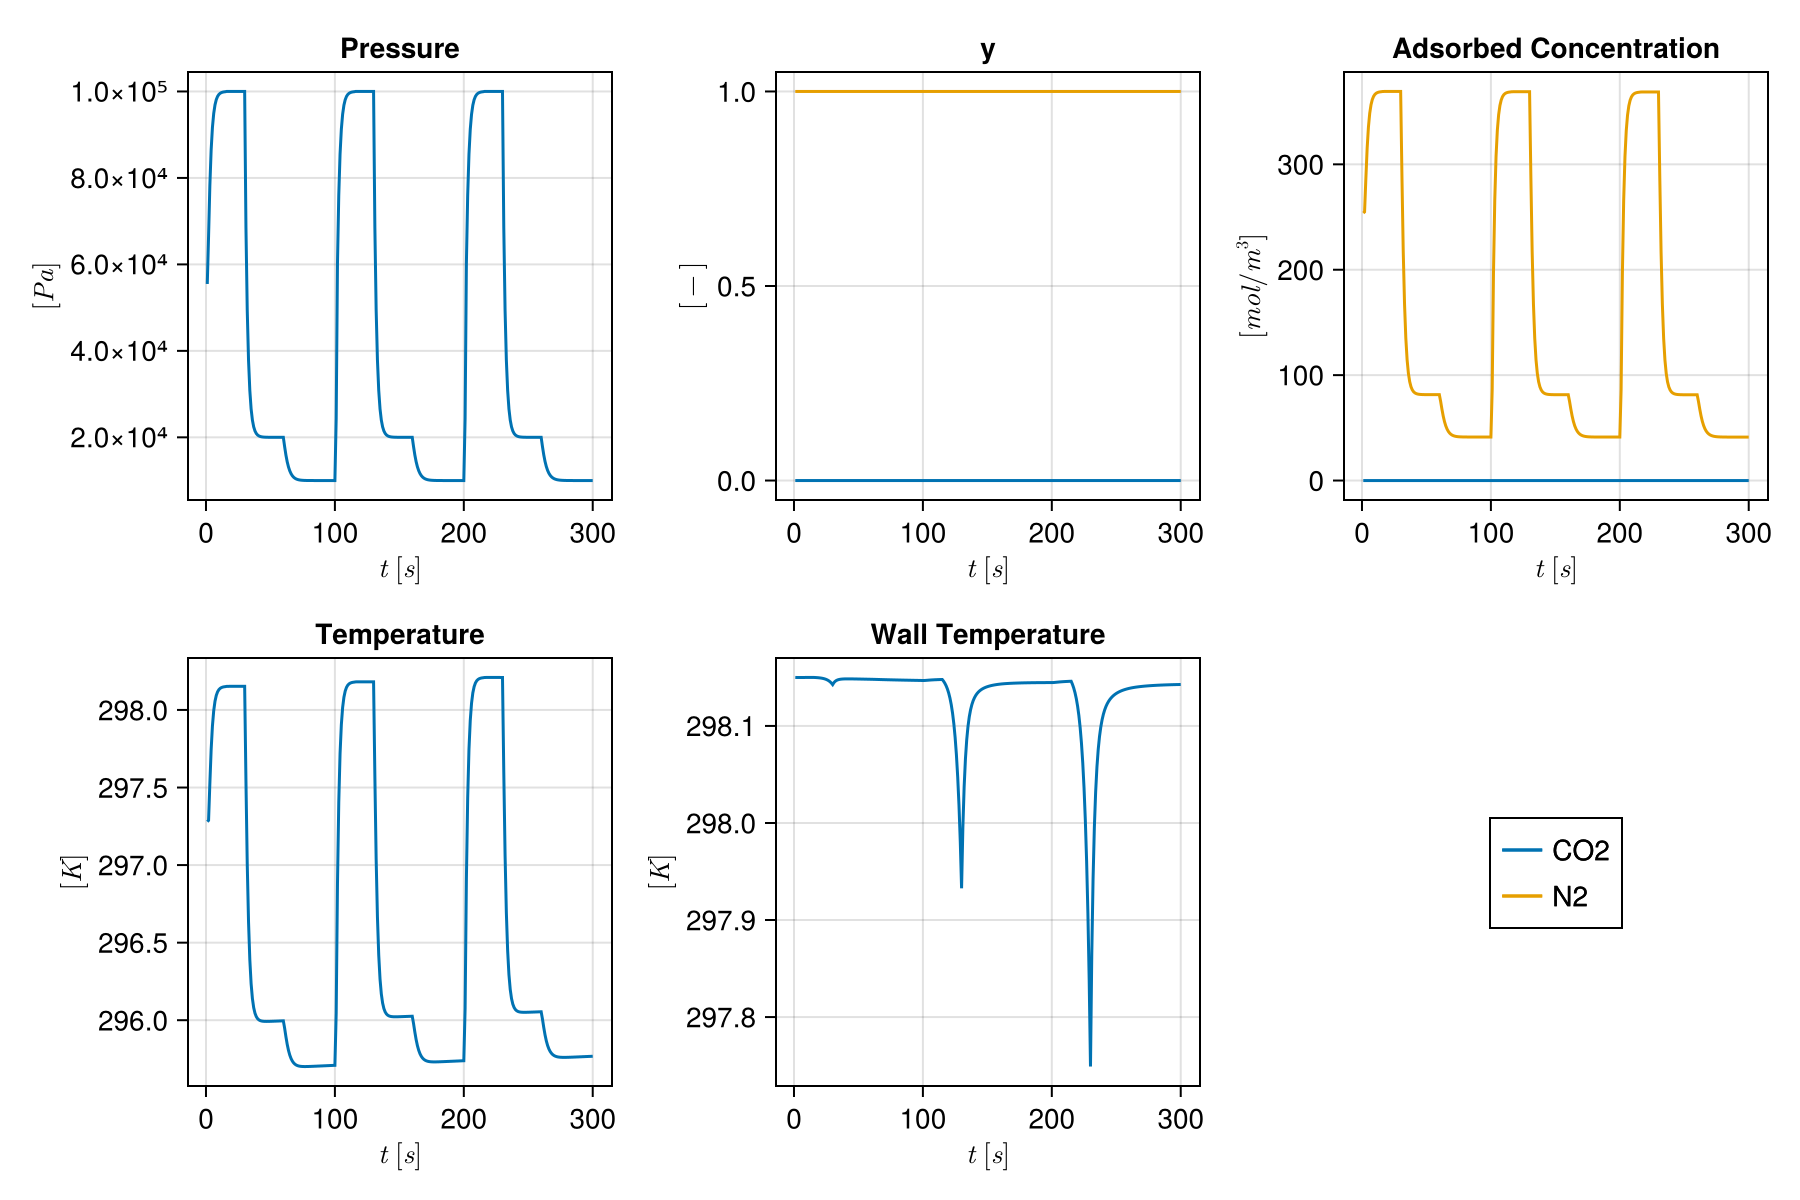

In [11]:
outlet_cell = ncells
f_outlet = Mocca.plot_cell(states, model, timesteps, outlet_cell)

We also plot primary variables along the column at the end of the simulation

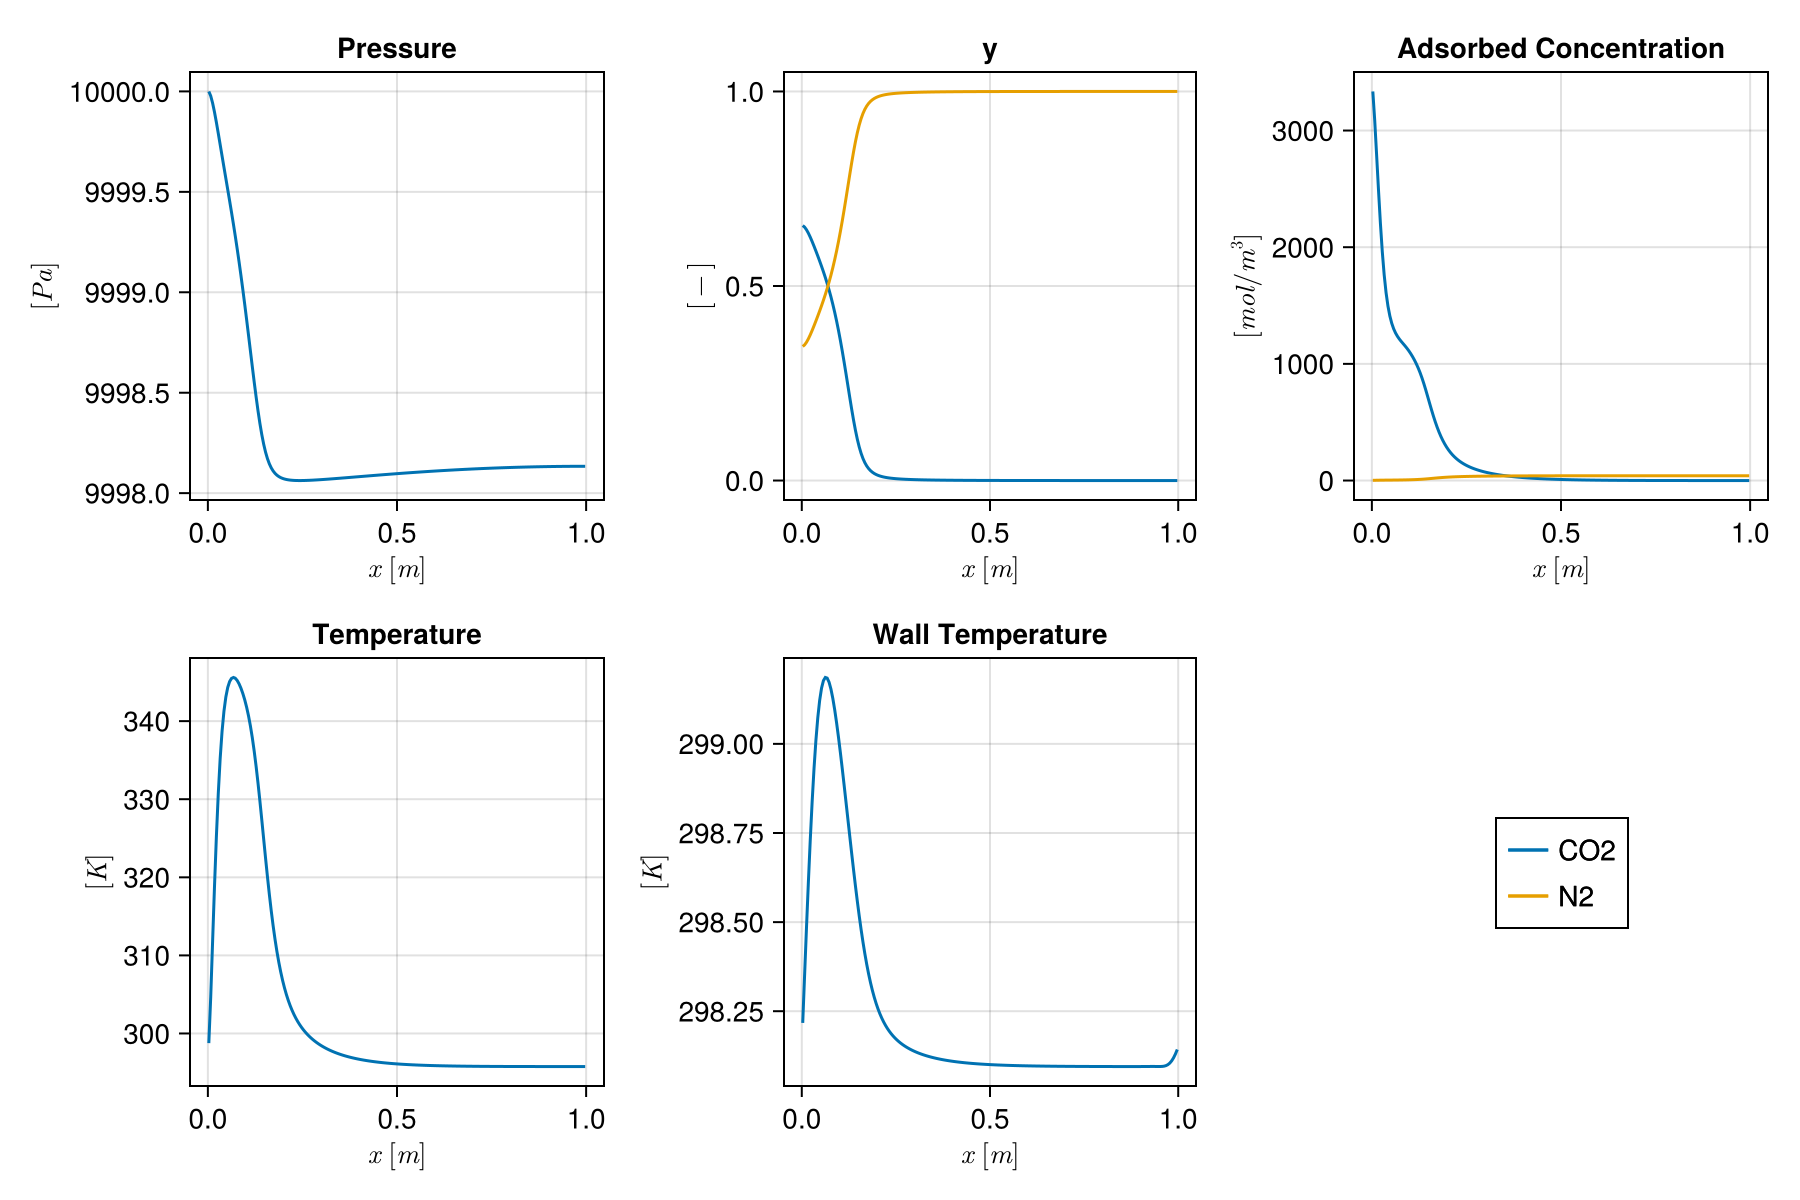

In [12]:
f_column = Mocca.plot_state(states[end], model)

## Example on GitHub
If you would like to run this example yourself, it can be downloaded from [the Mocca.jl GitHub repository](https://github.com/sintefmath/Mocca.jl/blob/main/examples/simulate_cyclic.jl).

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*